In [40]:
from testutils import *

In [41]:
prenoise_signal, signal, samp

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.00000000e+00, -1.37144847e-43, -5.90328372e-33, ...,
        -5.84356257e-33, -1.36245267e-43, -0.00000000e+00]),
 4.726490635880197e-06)

In [42]:
import bilby
from bilby.gw.detector.psd import PowerSpectralDensity as psd
minimum_frequency = 7
maximum_frequency = 4096
from gwpy.timeseries import TimeSeries
gwpy_signal = TimeSeries(signal, dt=samp)
print(gwpy_signal.duration)
CE40 = bilby.gw.detector.Interferometer(name = "CE40",
                                        power_spectral_density = psd.from_amplitude_spectral_density_file('CE40-asd.txt'),
                                        minimum_frequency = minimum_frequency,
                                        maximum_frequency = maximum_frequency,
                                        length = 40, 
                                        latitude = 46,
                                        longitude = -125,
                                        xarm_azimuth = 260,
                                        yarm_azimuth = 350,
                                        elevation = 0)

0.09452981271760394 s


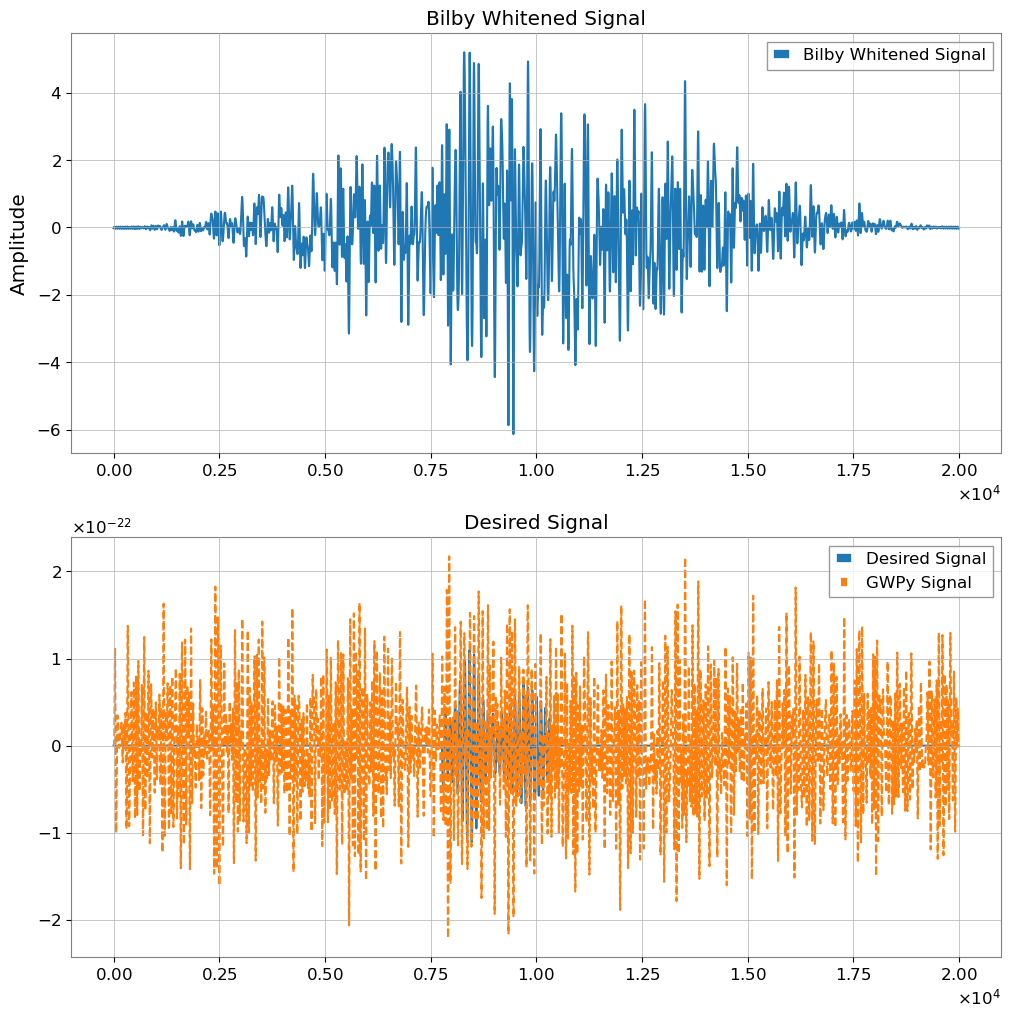

In [72]:
CE40.set_strain_data_from_gwpy_timeseries(gwpy_signal)
plt.figure(figsize=(12, 12))

plt.subplot(211)
plt.plot(CE40.whitened_time_domain_strain, label="Bilby Whitened Signal")
plt.title("Bilby Whitened Signal")
# plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

plt.subplot(212)
plt.plot(prenoise_signal, label="Desired Signal")
plt.plot(signal, label="GWPy Signal", linestyle='--')
plt.title("Desired Signal")
plt.grid(True)
plt.legend()
plt.show()

In [44]:
def nfft(time_domain_strain, sampling_frequency):
    """ Perform an FFT while keeping track of the frequency bins. Assumes input
        time series is real (positive frequencies only).

    Parameters
    ==========
    time_domain_strain: array_like
        Time series of strain data.
    sampling_frequency: float
        Sampling frequency of the data.

    Returns
    =======
    frequency_domain_strain, frequency_array: (array_like, array_like)
        Single-sided FFT of time domain strain normalised to units of
        strain / Hz, and the associated frequency_array.

    """
    frequency_domain_strain = np.fft.rfft(time_domain_strain)
    frequency_domain_strain /= sampling_frequency

    frequency_array = np.linspace(
        0, sampling_frequency / 2, len(frequency_domain_strain))

    return frequency_domain_strain, frequency_array


def infft(frequency_domain_strain, sampling_frequency):
    """ Inverse FFT for use in conjunction with nfft.

    Parameters
    ==========
    frequency_domain_strain: array_like
        Single-sided, normalised FFT of the time-domain strain data (in units
        of strain / Hz).
    sampling_frequency: int, float
        Sampling frequency of the data.

    Returns
    =======
    time_domain_strain: array_like
        An array of the time domain strain
    """
    time_domain_strain_norm = np.fft.irfft(frequency_domain_strain)
    time_domain_strain = time_domain_strain_norm * sampling_frequency
    return time_domain_strain


In [45]:
duration = len(signal)*samp
rolloff = .1
alpha = 2*rolloff*duration
samf = 1/samp
window = scipy.signal.windows.tukey(len(signal), rolloff)
window_factor = np.mean(window)

In [46]:
fds, freqs = nfft(signal*window, samf)
detectable_fds = fds.copy()
detectable_fds[freqs > 5000] = 0